# Lectures 8: Class demo

### Imports

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from utils import *
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
%matplotlib inline
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- For example, with the sign and magnitude of learned coefficients we could answer questions such as which features are driving the prediction to which direction. 

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [2]:
imdb_df = pd.read_csv("../data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df["label"].str.startswith(("pos", "neg"))]
imdb_df.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb_df.head()

,review,label
0,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the charact...",neg
1,"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and...",neg
2,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangst...",neg
3,"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social pla...",neg
4,Brass pictures (movies is not a fitting word for them) really are somewhat brassy. Their alluring visual qualities are reminiscent of expensive high class TV commercials. But unfortunately Brass p...,neg


Let's clean up the data a bit. 

In [3]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub("https://\S*", "", doc)
    return doc

In [4]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [5]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["label"]
X_test, y_test = test_df["review_pp"], test_df["label"]
train_df.shape

(5000, 3)

In [6]:
vec = CountVectorizer(stop_words="english")
bow = vec.fit_transform(X_train)
bow

<5000x38153 sparse matrix of type '<class 'numpy.int64'>'
	with 433027 stored elements in Compressed Sparse Row format>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names_out()` on the `CountVectorizer` object. 

In [7]:
vocab = vec.get_feature_names_out()

In [8]:
vocab[0:10]  # first few words

array(['00', '000', '00015', '007', '0093638', '00pm', '00s', '01', '02',
       '03'], dtype=object)

In [9]:
vocab[2000:2010]  # some middle words

array(['arabs', 'arachnids', 'aragorn', 'aran', 'araãºjo', 'arbiter',
       'arbitrarily', 'arbitrary', 'arbogast', 'arbor'], dtype=object)

In [10]:
vocab[::500]  # words with a step of 500

array(['00', '_everything_', 'aesthetics', 'amelia', 'arabs', 'atwill',
       'barbour', 'bereft', 'blunders', 'breathy', 'butterfly', 'cashed',
       'chemical', 'clint', 'compiling', 'controlness', 'creeping',
       'dandruff', 'delusional', 'differentiate', 'divya', 'ds',
       'electra', 'envisage', 'expecially', 'faze', 'flesh', 'freely',
       'gellar', 'gomez', 'guilted', 'hastened', 'hilly', 'hullabaloo',
       'imprisons', 'insists', 'ivor', 'jungles', 'kolonel', 'lds',
       'listens', 'ma', 'markings', 'melee', 'mishap', 'mourned',
       'needless', 'nudge', 'org', 'panoply', 'perceptive', 'pizza',
       'pour', 'promoters', 'quilty', 'reccoemnd', 'repaid', 'riders',
       'ruining', 'scaring', 'senselessly', 'short', 'slasher', 'sonja',
       'squishes', 'stratas', 'superlative', 'talley', 'theories',
       'tormentors', 'trows', 'understatement', 'uprooted', 'vilifies',
       'waxman', 'withdraw', 'yyz'], dtype=object)

In [11]:
y_train.value_counts()

label
neg    2525
pos    2475
Name: count, dtype: int64

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [12]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001551,0.001493,0.505,0.505
1,0.001266,0.001120,0.505,0.505
2,0.001259,0.001061,0.505,0.505
3,0.001214,0.001099,0.505,0.505
4,0.001237,0.001087,0.505,0.505


We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [13]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000),
)
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.648565,0.089887,0.851,1.0
1,0.641437,0.087010,0.834,1.0
2,0.632287,0.088347,0.838,1.0
3,0.676811,0.083822,0.859,1.0
4,0.644781,0.086424,0.840,1.0


Seems like we are overfitting. Let's optimize the hyperparameter `C` of LR and `max_features` of `CountVectorizer`. 

In [14]:
from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "countvectorizer__max_features": randint(10, len(vocab)),
    "logisticregression__C": loguniform(1e-3, 1e3)
}
pipe_lr = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000))
random_search = RandomizedSearchCV(pipe_lr, param_dist, n_iter=10, n_jobs=-1, return_train_score=True)
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(stop_words='english')),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16f8a7880>,
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16f8a6a70>},
                   return_train_score=True)

In [15]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.887960,0.031929,0.129097,0.006647,3690,447.077429,"{'countvectorizer__max_features': 3690, 'logisticregression__C': 447.07742899169847}",0.823,0.800,0.808,...,0.8104,0.009135,8,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000
1,0.889278,0.033943,0.123936,0.004859,2541,912.930835,"{'countvectorizer__max_features': 2541, 'logisticregression__C': 912.9308349152036}",0.821,0.795,0.805,...,0.8010,0.011713,10,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000
2,0.747122,0.071033,0.130589,0.005867,22317,0.056543,"{'countvectorizer__max_features': 22317, 'logisticregression__C': 0.056542860051277476}",0.861,0.853,0.850,...,0.8558,0.007139,1,0.97675,0.9800,0.97975,0.98025,0.98200,0.97975,0.001696
3,0.978819,0.047634,0.132974,0.006072,17016,910.358522,"{'countvectorizer__max_features': 17016, 'logisticregression__C': 910.3585221562778}",0.843,0.826,0.827,...,0.8336,0.008114,6,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000
4,0.698466,0.057317,0.137204,0.009667,9733,0.030182,"{'countvectorizer__max_features': 9733, 'logisticregression__C': 0.03018189029798178}",0.852,0.852,0.852,...,0.8532,0.005269,2,0.95650,0.9590,0.95775,0.95800,0.95775,0.95780,0.000797
5,1.119875,0.046236,0.137406,0.008026,25540,32.463393,"{'countvectorizer__max_features': 25540, 'logisticregression__C': 32.46339324613553}",0.846,0.825,0.832,...,0.8378,0.010186,4,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000
6,0.645274,0.029789,0.118591,0.008782,570,0.307999,"{'countvectorizer__max_features': 570, 'logisticregression__C': 0.3079991489892481}",0.824,0.797,0.807,...,0.8102,0.011338,9,0.88300,0.8875,0.88925,0.88100,0.88925,0.88600,0.003387
7,0.587483,0.013845,0.129797,0.019168,2215,0.008403,"{'countvectorizer__max_features': 2215, 'logisticregression__C': 0.008402692418779856}",0.827,0.832,0.833,...,0.8376,0.009790,5,0.89350,0.8965,0.89175,0.88875,0.89175,0.89245,0.002537
8,0.743434,0.053850,0.127350,0.005814,3764,8.112047,"{'countvectorizer__max_features': 3764, 'logisticregression__C': 8.112047408258451}",0.827,0.803,0.824,...,0.8198,0.010833,7,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000
9,0.906519,0.097151,0.115202,0.022380,21987,6.429147,"{'countvectorizer__max_features': 21987, 'logisticregression__C': 6.429147249317815}",0.845,0.827,0.835,...,0.8392,0.009347,3,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,0.000000


In [16]:
cv_scores = random_search.cv_results_['mean_test_score']
train_scores = random_search.cv_results_['mean_train_score']
countvec_max_features = random_search.cv_results_['param_countvectorizer__max_features']

In [17]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",        
        "param_logisticregression__C",
        "param_countvectorizer__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

,mean_test_score,mean_train_score,param_logisticregression__C,param_countvectorizer__max_features,mean_fit_time
rank_test_score,,,,,
1,0.8558,0.97975,0.056543,22317,0.747122
2,0.8532,0.95780,0.030182,9733,0.698466
3,0.8392,1.00000,6.429147,21987,0.906519
4,0.8378,1.00000,32.463393,25540,1.119875
5,0.8376,0.89245,0.008403,2215,0.587483
6,0.8336,1.00000,910.358522,17016,0.978819
7,0.8198,1.00000,8.112047,3764,0.743434
8,0.8104,1.00000,447.077429,3690,0.887960
9,0.8102,0.88600,0.307999,570,0.645274


Let's train a model on the full training set with the optimized hyperparameter values. 

In [18]:
best_model = random_search.best_estimator_

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [19]:
# Get feature names
feature_names = best_model.named_steps['countvectorizer'].get_feature_names_out().tolist()

# Get coefficients 
coeffs = best_model.named_steps["logisticregression"].coef_.flatten()

In [20]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,-0.054476
000,-0.058816
007,0.004202
01,-0.019589
02,-0.025555
...,...
zulu,-0.033189
zuniga,-0.026531
â½,0.004713
ãªtre,-0.023960


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [21]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.754531
great,0.598293
wonderful,0.539038
amazing,0.535003
favorite,0.487617
...,...
terrible,-0.528488
boring,-0.582887
waste,-0.645884
bad,-0.674181


- The coefficients make sense!

Let's visualize the top 20 features.

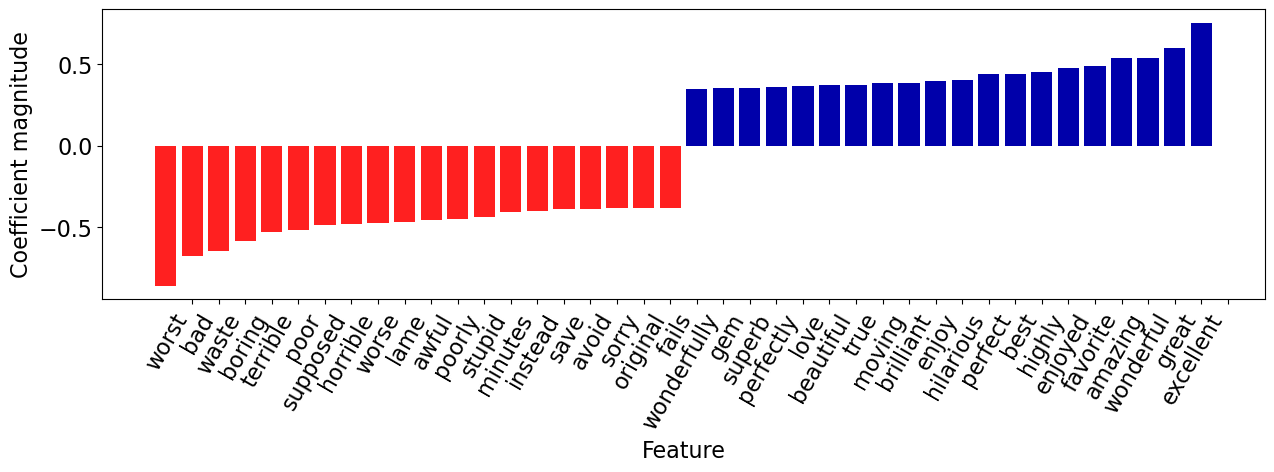

In [22]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [23]:
fake_reviews = ["It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!",
 "The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen."
]

Let's get prediction probability scores of the fake review. 

In [24]:
best_model.predict(fake_reviews)

array(['pos', 'neg'], dtype=object)

In [25]:
# Get prediction probabilities for fake reviews 
best_model.predict_proba(fake_reviews)

array([[0.20880123, 0.79119877],
       [0.64462303, 0.35537697]])

In [26]:
best_model.classes_

array(['neg', 'pos'], dtype=object)

We can find which of the vocabulary words are present in this review:

In [27]:
def plot_coeff_example(model, review, coeffs, feature_names, n_top_feats=6):
    print(review)
    feat_vec = model.named_steps["countvectorizer"].transform([review])
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=n_top_feats
    )
    return ex_df.sort_values(by=["Coefficient"], ascending=False)

It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!


,Coefficient
excellent,0.754531
enjoyed,0.475706
highly,0.450138
bit,0.332370
overall,0.119454
times,0.110395
flawless,0.078456
recommend,0.066069
movie,-0.035531
got,-0.104489


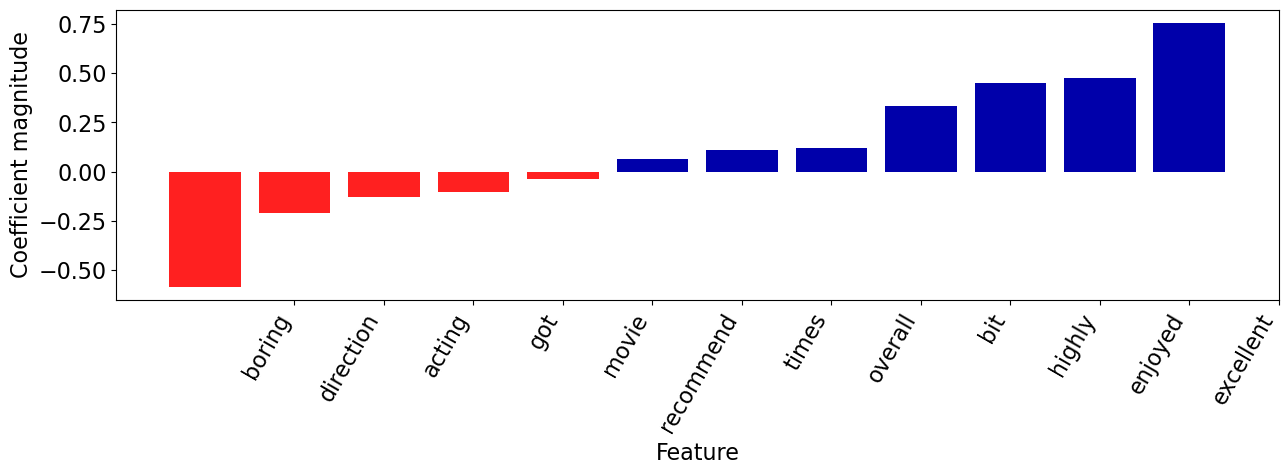

In [28]:
plot_coeff_example(best_model, fake_reviews[0], coeffs, feature_names)

The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen.


,Coefficient
know,0.100463
pool,0.000071
big,-0.021950
screen,-0.024977
hey,-0.025391
stick,-0.047701
plot,-0.192990
avoid,-0.387191


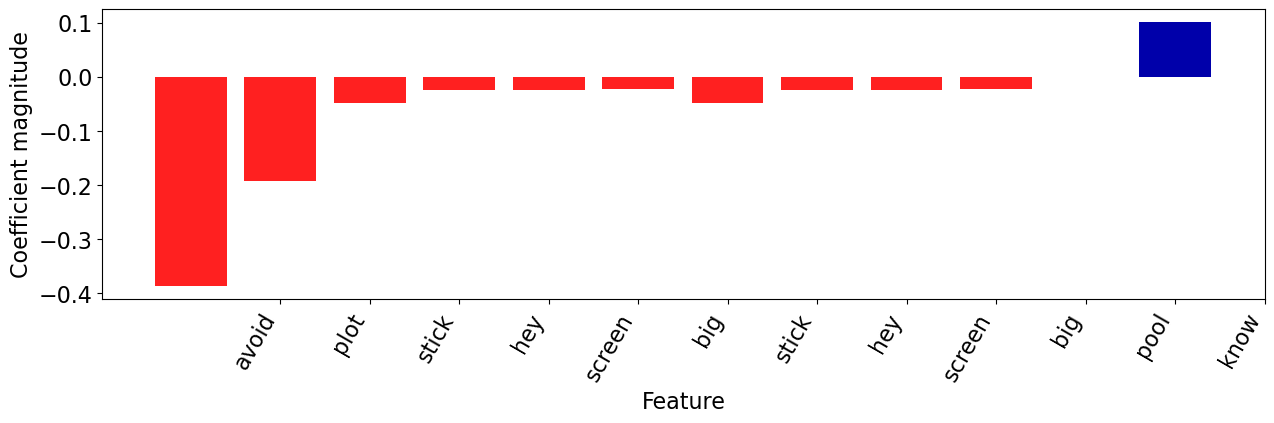

In [29]:
plot_coeff_example(best_model, fake_reviews[1], coeffs, feature_names)

<br><br><br><br>

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most certain or least certain?

In [30]:
# only get probabilities associated with pos class
pos_probs = best_model.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.93149138, 0.82269379, 0.8832539 , ..., 0.87023258, 0.08331949,
       0.7576988 ])

What's the index of the example where the classifier is most certain (highest `predict_proba` score for positive)?

In [31]:
most_positive_id = np.argmax(pos_probs)

In [32]:
print("True target: %s\n" % (y_train.iloc[most_positive_id]))
print("Predicted target: %s\n" % (best_model.predict(X_train.iloc[[most_positive_id]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive_id]))

True target: pos

Predicted target: pos

Prediction probability: 1.0000


Let's examine the features associated with the review. 

Moving beyond words is this heart breaking story of a divorce which results in a tragic custody battle over a seven year old boy.  One of "Kramer v. Kramer's" great strengths is its screenwriter director Robert Benton, who has marvellously adapted Avery Corman's novel to the big screen. He keeps things beautifully simple and most realistic, while delivering all the drama straight from the heart. His talent for telling emotional tales like this was to prove itself again with "Places in the Heart", where he showed, as in "Kramer v. Kramer", that he has a natural ability for working with children.  The picture's other strong point is the splendid acting which deservedly received four of the film's nine Academy Award nominations, two of them walking away winners. One of those was Dustin Hoffman (Best Actor), who is superb as frustrated business man Ted Kramer, a man who has forgotten that his wife is a person. As said wife Joanne, Meryl Streep claimed the supporting actress Oscar for a str

,Coefficient
excellent,0.754531
great,0.598293
wonderful,0.539038
highly,0.450138
best,0.440914
...,...
director,-0.189219
piece,-0.192853
child,-0.203941
direction,-0.207460


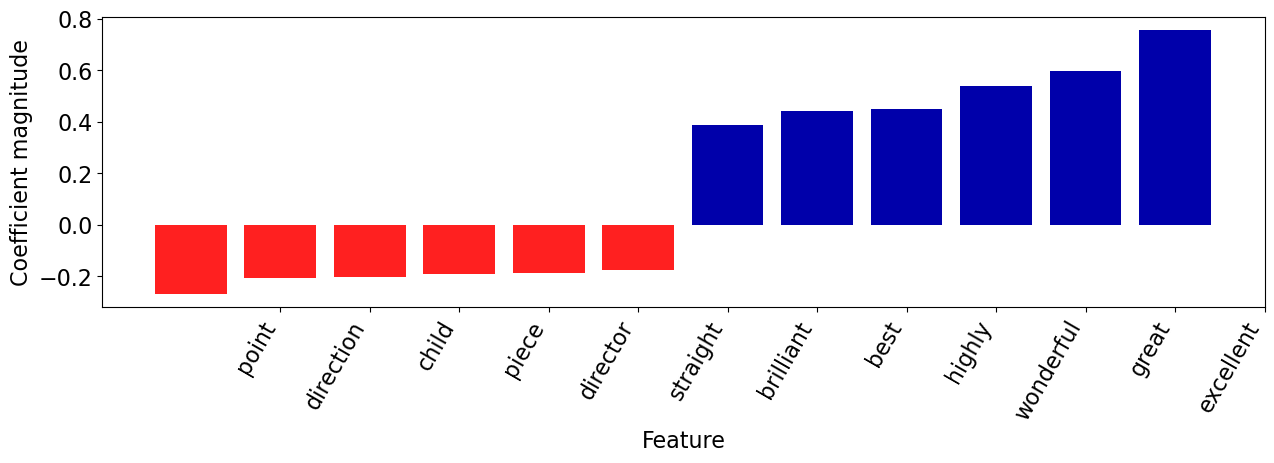

In [33]:
plot_coeff_example(best_model, X_train.iloc[most_positive_id], coeffs, feature_names)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [34]:
neg_probs = best_model.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with neg class
neg_probs

array([0.06850862, 0.17730621, 0.1167461 , ..., 0.12976742, 0.91668051,
       0.2423012 ])

In [35]:
most_negative_id = np.argmax(neg_probs)

In [36]:
print("Review: %s\n" % (X_train.iloc[[most_negative_id]]))
print("True target: %s\n" % (y_train.iloc[most_negative_id]))
print("Predicted target: %s\n" % (best_model.predict(X_train.iloc[[most_negative_id]])[0]))
print("Prediction probability: %0.4f" % (neg_probs[most_negative_id]))

Review: 36555    I made the big mistake of actually watching this whole movie a few nights ago. God I'm still trying to recover. This movie does not even deserve a 1.4 average. IMDb needs to have 0 vote ratings po...
Name: review_pp, dtype: object

True target: neg

Predicted target: neg

Prediction probability: 1.0000


I made the big mistake of actually watching this whole movie a few nights ago. God I'm still trying to recover. This movie does not even deserve a 1.4 average. IMDb needs to have 0 vote ratings possible for movies that really deserve it like this one. A 1.4 is TOO HIGH.  I had heard how awful this movie was, but I really did not think a movie could actually be that bad, especially in this day and era. I figured all of the cheesy god awful movies were only from the 1950s and 1960s. My god was I wrong. Trust me folks, this movie REALLY IS THAT BAD. It is beyond horrible; it is beyond pathetic; it is beyond any type of word that I can think of for it. BATTLEFIELD EARTH looks like Best Picture of the Year compared to this movie. SNAKE ISLAND (which up until now was the worst movie I'd ever seen) looks like it deserves a few Oscars compared to this pathetic effort.  I seriously can not believe that the makers of this movie thought this was a legitimate serious effort of producing a Hollywoo

,Coefficient
best,0.440914
job,0.307902
music,0.302964
especially,0.289070
strong,0.262629
...,...
awful,-0.455976
worse,-0.474938
horrible,-0.481359
bad,-0.674181


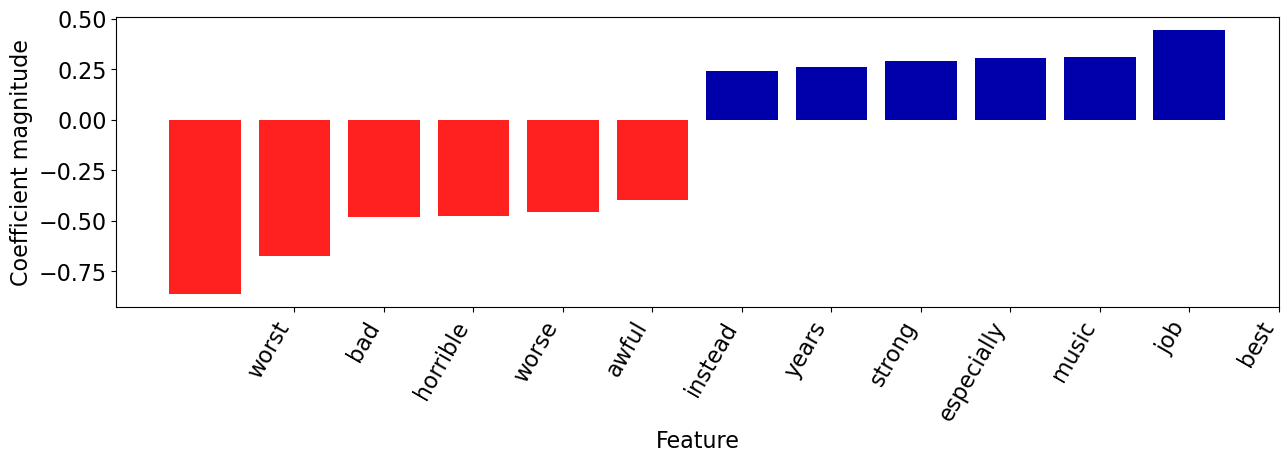

In [37]:
plot_coeff_example(best_model, X_train.iloc[most_negative_id], coeffs, feature_names)

The review has both positive and negative words but the words with negative coefficients win in this case! 

## ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  
